### import

In [1]:
import os
import sys
import torch
from torch import nn
from torch.nn import functional
from torch import optim
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST 
from torchvision import transforms as tr
import numpy as np
from tqdm import tqdm # train할때 progress bar를 보여줌
import matplotlib.pyplot as plt

In [7]:
project_root = "C:/Users/rlduf/Desktop/Github/DeepLearning"
sys.path.append(project_root)
data_root = os.path.join(os.getcwd(), "data")

In [8]:
# torch.utils.data.random_split을 사용할 수 있음
# 하지만 이 방법은 label의 비율을 고려하지 않았기 때문에 정확도가 떨어질 수 있음
# 따라서 data_utils.py 파일의 dataset_split 함수 import
from data_utils import dataset_split 

### Preprocessing & Dataset

In [9]:
transform = tr.Compose( 
    [
        tr.ToTensor(), # PIL Image나 NumPy ndarray 를 FloatTensor 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)
        tr.Normalize([0.5], [0.5]) # Normalize a tensor image with mean and standard deviation
    ]
)

fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform) 

In [10]:
dataset = dataset_split(fashion_mnist_dataset, split=[0.9, 0.1])
print(dataset) # dict 형태

{'train': <torch.utils.data.dataset.Subset object at 0x000001EE4271EC88>, 'val': <torch.utils.data.dataset.Subset object at 0x000001EE4271ED08>}


In [12]:
train_dataset = dataset['train']
val_dataset = dataset['val']

train_batch_size = 64
val_batch_size = 64

### DataLoader

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1 # num_workers는 병렬처리할 때 사용
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=1
)

### Model

In [14]:
class MLP(nn.Module):
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)

    def forward(self, input):
        x = torch.flatten(input, start_dim = 1)
        # forward method에서 사용할거면 nn.functional.relu를 사용 / nn.Sequential 안에 사용할거면 nn.ReLU()를 사용
        x = functional.relu(self.linear1(x))
        x = functional.relu(self.linear2(x))
        out = self.linear3(x)
        return out

### Loss Fucntion, Optimization, Tensorboard

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
# model
model = MLP(28*28, 128, 64, 10).to(device)

# define loss
loss_function = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epoch = 10

In [17]:
# do train with validation.
train_step = 0
for epoch in range(1, max_epoch+1):
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc="validation")
        ):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            # forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            # loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
    
    # valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    
    print(
        f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}\n"
    )

    
    # train step
    current_loss = 0
    current_corrects = 0
    model.train()

    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc="training")
    ):
        current_loss = 0.0
        current_corrects = 0

        # Forward
        # get predictions
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # get loss (Loss 계산)
        loss = loss_function(outputs, labels)

        # Backpropagation
        # optimizer 초기화 (zero화)
        optimizer.zero_grad()

        # Perform backward pass
        loss.backward()

        # Perform Optimization
        optimizer.step()

        current_loss += loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % 100 == 0:
            train_loss = current_loss / 100
            train_acc = current_corrects / 100

            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}"
            )
            current_loss = 0
            current_corrects = 0

        train_step += 1

    print('\n')

validation: 100%|██████████| 94/94 [00:05<00:00, 18.53it/s]


1 epoch, 0 step: val_loss: 0.0361255407333374, val_acc: 0.13314494490623474



training:   1%|▏         | 12/844 [00:01<01:10, 11.87it/s]

0: train_loss: 0.023087167739868165, train_acc: 0.05999999865889549


training:  13%|█▎        | 109/844 [00:02<00:07, 92.25it/s]

100: train_loss: 0.00758567214012146, train_acc: 0.5


training:  26%|██▌       | 219/844 [00:03<00:06, 101.06it/s]

200: train_loss: 0.004056741893291474, train_acc: 0.5299999713897705


training:  38%|███▊      | 317/844 [00:04<00:05, 101.52it/s]

300: train_loss: 0.0031870782375335695, train_acc: 0.5600000023841858


training:  49%|████▉     | 416/844 [00:05<00:04, 101.15it/s]

400: train_loss: 0.003956044614315033, train_acc: 0.5299999713897705


training:  61%|██████    | 515/844 [00:06<00:03, 101.94it/s]

500: train_loss: 0.0060383850336074825, train_acc: 0.5


training:  73%|███████▎  | 614/844 [00:07<00:02, 101.39it/s]

600: train_loss: 0.004753440618515015, train_acc: 0.5399999618530273


training:  84%|████████▍ | 713/844 [00:08<00:01, 101.41it/s]

700: train_loss: 0.003277493417263031, train_acc: 0.5699999928474426


training:  96%|█████████▌| 812/844 [00:09<00:00, 103.12it/s]

800: train_loss: 0.0049218833446502686, train_acc: 0.5299999713897705


training: 100%|██████████| 844/844 [00:09<00:00, 86.66it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 42.09it/s]


2 epoch, 844 step: val_loss: 0.006487911567091942, val_acc: 0.8460216522216797



training:   9%|▉         | 77/844 [00:02<00:09, 77.67it/s]

900: train_loss: 0.006169763803482056, train_acc: 0.5299999713897705


training:  20%|█▉        | 165/844 [00:02<00:06, 102.25it/s]

1000: train_loss: 0.004300080835819244, train_acc: 0.5699999928474426


training:  31%|███▏      | 264/844 [00:03<00:05, 101.60it/s]

1100: train_loss: 0.0040984821319580075, train_acc: 0.5399999618530273


training:  44%|████▍     | 374/844 [00:04<00:04, 102.36it/s]

1200: train_loss: 0.0063949495553970335, train_acc: 0.5


training:  56%|█████▌    | 473/844 [00:05<00:03, 105.30it/s]

1300: train_loss: 0.0030755165219306948, train_acc: 0.5799999833106995


training:  68%|██████▊   | 572/844 [00:06<00:02, 102.44it/s]

1400: train_loss: 0.004386864602565765, train_acc: 0.5099999904632568


training:  80%|███████▉  | 671/844 [00:07<00:01, 104.88it/s]

1500: train_loss: 0.0034275740385055543, train_acc: 0.5699999928474426


training:  91%|█████████ | 770/844 [00:08<00:00, 104.89it/s]

1600: train_loss: 0.004227702617645264, train_acc: 0.5600000023841858


training: 100%|██████████| 844/844 [00:09<00:00, 87.95it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 41.69it/s]


3 epoch, 1688 step: val_loss: 0.005839274264872074, val_acc: 0.8585993051528931



training:   4%|▍         | 32/844 [00:01<00:23, 34.88it/s]

1700: train_loss: 0.003549230694770813, train_acc: 0.5399999618530273


training:  15%|█▌        | 130/844 [00:02<00:07, 97.54it/s]

1800: train_loss: 0.004072924554347992, train_acc: 0.550000011920929


training:  27%|██▋       | 229/844 [00:03<00:05, 103.25it/s]

1900: train_loss: 0.004181178510189057, train_acc: 0.5600000023841858


training:  39%|███▉      | 328/844 [00:04<00:04, 104.57it/s]

2000: train_loss: 0.00457472413778305, train_acc: 0.5199999809265137


training:  51%|█████     | 427/844 [00:05<00:03, 105.56it/s]

2100: train_loss: 0.0023996645212173463, train_acc: 0.5899999737739563


training:  62%|██████▏   | 526/844 [00:06<00:03, 104.17it/s]

2200: train_loss: 0.0013434098660945893, train_acc: 0.6299999952316284


training:  74%|███████▍  | 625/844 [00:07<00:02, 103.69it/s]

2300: train_loss: 0.0023491568863391876, train_acc: 0.5899999737739563


training:  86%|████████▌ | 724/844 [00:08<00:01, 102.72it/s]

2400: train_loss: 0.003300771713256836, train_acc: 0.550000011920929


training:  98%|█████████▊| 823/844 [00:09<00:00, 103.67it/s]

2500: train_loss: 0.004965620636940002, train_acc: 0.5199999809265137


training: 100%|██████████| 844/844 [00:09<00:00, 87.76it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 40.60it/s]


4 epoch, 2532 step: val_loss: 0.0056637548841536045, val_acc: 0.8702349066734314



training:  10%|█         | 86/844 [00:02<00:09, 81.93it/s]

2600: train_loss: 0.0037775567173957826, train_acc: 0.5299999713897705


training:  21%|██▏       | 180/844 [00:03<00:06, 96.97it/s]

2700: train_loss: 0.0036547186970710753, train_acc: 0.5600000023841858


training:  34%|███▍      | 287/844 [00:04<00:05, 98.59it/s] 

2800: train_loss: 0.003160664737224579, train_acc: 0.550000011920929


training:  46%|████▌     | 386/844 [00:05<00:04, 101.43it/s]

2900: train_loss: 0.002399389147758484, train_acc: 0.550000011920929


training:  57%|█████▋    | 484/844 [00:06<00:03, 99.64it/s] 

3000: train_loss: 0.00390448123216629, train_acc: 0.550000011920929


training:  69%|██████▉   | 583/844 [00:07<00:02, 101.40it/s]

3100: train_loss: 0.002459717094898224, train_acc: 0.5699999928474426


training:  81%|████████  | 682/844 [00:08<00:01, 100.94it/s]

3200: train_loss: 0.0022279830276966095, train_acc: 0.5999999642372131


training:  93%|█████████▎| 781/844 [00:09<00:00, 101.98it/s]

3300: train_loss: 0.004888282418251038, train_acc: 0.5299999713897705


training: 100%|██████████| 844/844 [00:09<00:00, 85.07it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 41.96it/s]


5 epoch, 3376 step: val_loss: 0.0053933667950332165, val_acc: 0.8759973049163818



training:   5%|▌         | 43/844 [00:01<00:16, 48.22it/s]

3400: train_loss: 0.002964993417263031, train_acc: 0.5699999928474426


training:  17%|█▋        | 142/844 [00:02<00:06, 101.06it/s]

3500: train_loss: 0.0024472200870513917, train_acc: 0.5699999928474426


training:  29%|██▊       | 241/844 [00:03<00:05, 103.19it/s]

3600: train_loss: 0.003482579290866852, train_acc: 0.5600000023841858


training:  40%|████      | 340/844 [00:04<00:04, 104.41it/s]

3700: train_loss: 0.006191076040267945, train_acc: 0.4899999797344208


training:  52%|█████▏    | 439/844 [00:05<00:03, 103.70it/s]

3800: train_loss: 0.002263151407241821, train_acc: 0.5699999928474426


training:  64%|██████▎   | 538/844 [00:06<00:02, 103.10it/s]

3900: train_loss: 0.0030323359370231628, train_acc: 0.5399999618530273


training:  75%|███████▌  | 637/844 [00:07<00:02, 101.54it/s]

4000: train_loss: 0.003299752175807953, train_acc: 0.5699999928474426


training:  87%|████████▋ | 736/844 [00:08<00:01, 103.67it/s]

4100: train_loss: 0.0019221791625022887, train_acc: 0.5999999642372131


training:  99%|█████████▉| 835/844 [00:09<00:00, 102.95it/s]

4200: train_loss: 0.003018782138824463, train_acc: 0.5799999833106995


training: 100%|██████████| 844/844 [00:09<00:00, 87.97it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 42.19it/s]


6 epoch, 4220 step: val_loss: 0.005552365444600582, val_acc: 0.8730052709579468



training:  11%|█▏        | 97/844 [00:02<00:08, 88.42it/s]

4300: train_loss: 0.002753337323665619, train_acc: 0.5799999833106995


training:  23%|██▎       | 196/844 [00:03<00:06, 102.65it/s]

4400: train_loss: 0.0025567078590393068, train_acc: 0.5699999928474426


training:  35%|███▍      | 295/844 [00:04<00:05, 101.29it/s]

4500: train_loss: 0.0038886401057243347, train_acc: 0.5299999713897705


training:  47%|████▋     | 394/844 [00:05<00:04, 102.91it/s]

4600: train_loss: 0.002640177011489868, train_acc: 0.5899999737739563


training:  58%|█████▊    | 493/844 [00:06<00:03, 103.30it/s]

4700: train_loss: 0.0030140897631645205, train_acc: 0.5600000023841858


training:  70%|███████   | 592/844 [00:07<00:02, 99.43it/s] 

4800: train_loss: 0.0012117915600538254, train_acc: 0.6200000047683716


training:  82%|████████▏ | 691/844 [00:08<00:01, 102.19it/s]

4900: train_loss: 0.0030111873149871824, train_acc: 0.5699999928474426


training:  95%|█████████▍| 801/844 [00:09<00:00, 103.81it/s]

5000: train_loss: 0.001968657374382019, train_acc: 0.5699999928474426


training: 100%|██████████| 844/844 [00:09<00:00, 85.92it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 41.56it/s]


7 epoch, 5064 step: val_loss: 0.005118696019053459, val_acc: 0.8794879913330078



training:   5%|▌         | 45/844 [00:01<00:15, 50.09it/s]

5100: train_loss: 0.0022313371300697327, train_acc: 0.5899999737739563


training:  18%|█▊        | 155/844 [00:02<00:06, 102.44it/s]

5200: train_loss: 0.0020340058207511903, train_acc: 0.5999999642372131


training:  30%|███       | 254/844 [00:03<00:05, 104.81it/s]

5300: train_loss: 0.004289027154445648, train_acc: 0.5199999809265137


training:  42%|████▏     | 353/844 [00:04<00:04, 105.11it/s]

5400: train_loss: 0.0035573965311050415, train_acc: 0.5600000023841858


training:  54%|█████▎    | 452/844 [00:05<00:03, 104.04it/s]

5500: train_loss: 0.0034040960669517516, train_acc: 0.550000011920929


training:  65%|██████▌   | 551/844 [00:06<00:02, 105.23it/s]

5600: train_loss: 0.0026554521918296815, train_acc: 0.5799999833106995


training:  77%|███████▋  | 650/844 [00:07<00:01, 104.89it/s]

5700: train_loss: 0.002528635859489441, train_acc: 0.5600000023841858


training:  89%|████████▊ | 749/844 [00:08<00:00, 104.59it/s]

5800: train_loss: 0.003096200227737427, train_acc: 0.550000011920929


training:  99%|█████████▉| 837/844 [00:09<00:00, 105.01it/s]

5900: train_loss: 0.0034462770819664, train_acc: 0.5699999928474426


training: 100%|██████████| 844/844 [00:09<00:00, 89.30it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 41.74it/s]


8 epoch, 5908 step: val_loss: 0.0053001102060079575, val_acc: 0.8794879913330078



training:  13%|█▎        | 109/844 [00:02<00:07, 93.46it/s]

6000: train_loss: 0.002319510728120804, train_acc: 0.5999999642372131


training:  25%|██▍       | 208/844 [00:03<00:06, 103.46it/s]

6100: train_loss: 0.0025325074791908266, train_acc: 0.5899999737739563


training:  36%|███▋      | 307/844 [00:04<00:05, 103.70it/s]

6200: train_loss: 0.003977960348129273, train_acc: 0.5399999618530273


training:  48%|████▊     | 406/844 [00:05<00:04, 103.31it/s]

6300: train_loss: 0.0034307724237442015, train_acc: 0.5399999618530273


training:  60%|█████▉    | 505/844 [00:06<00:03, 105.33it/s]

6400: train_loss: 0.0028828364610671998, train_acc: 0.5799999833106995


training:  72%|███████▏  | 604/844 [00:07<00:02, 104.44it/s]

6500: train_loss: 0.0016626563668251037, train_acc: 0.5999999642372131


training:  85%|████████▍ | 714/844 [00:08<00:01, 102.16it/s]

6600: train_loss: 0.0026187193393707275, train_acc: 0.5999999642372131


training:  96%|█████████▋| 813/844 [00:09<00:00, 103.68it/s]

6700: train_loss: 0.0031498697400093078, train_acc: 0.5699999928474426


training: 100%|██████████| 844/844 [00:09<00:00, 88.68it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 40.54it/s]


9 epoch, 6752 step: val_loss: 0.00553114665672183, val_acc: 0.8694591522216797



training:   8%|▊         | 64/844 [00:01<00:11, 68.66it/s]

6800: train_loss: 0.001492038667201996, train_acc: 0.5999999642372131


training:  19%|█▉        | 163/844 [00:02<00:06, 101.42it/s]

6900: train_loss: 0.0029492855072021486, train_acc: 0.5699999928474426


training:  31%|███       | 262/844 [00:03<00:05, 104.13it/s]

7000: train_loss: 0.0025792539119720457, train_acc: 0.5699999928474426


training:  43%|████▎     | 361/844 [00:04<00:04, 101.08it/s]

7100: train_loss: 0.0024934084713459015, train_acc: 0.5600000023841858


training:  55%|█████▍    | 460/844 [00:05<00:03, 103.32it/s]

7200: train_loss: 0.001650802344083786, train_acc: 0.5999999642372131


training:  66%|██████▌   | 559/844 [00:06<00:02, 101.56it/s]

7300: train_loss: 0.0036708688735961914, train_acc: 0.5600000023841858


training:  78%|███████▊  | 658/844 [00:07<00:01, 103.34it/s]

7400: train_loss: 0.0017529527842998504, train_acc: 0.5799999833106995


training:  90%|████████▉ | 757/844 [00:08<00:00, 103.62it/s]

7500: train_loss: 0.0028253534436225893, train_acc: 0.5899999737739563


training: 100%|██████████| 844/844 [00:09<00:00, 87.44it/s] 


validation: 100%|██████████| 94/94 [00:02<00:00, 42.08it/s]


10 epoch, 7596 step: val_loss: 0.005079146008938551, val_acc: 0.8814272284507751



training:   2%|▏         | 21/844 [00:01<00:41, 19.98it/s]

7600: train_loss: 0.0016856200993061066, train_acc: 0.5899999737739563


training:  14%|█▍        | 120/844 [00:02<00:07, 96.27it/s]

7700: train_loss: 0.002230429947376251, train_acc: 0.5899999737739563


training:  26%|██▌       | 219/844 [00:03<00:06, 103.55it/s]

7800: train_loss: 0.003601040840148926, train_acc: 0.5199999809265137


training:  38%|███▊      | 318/844 [00:04<00:05, 104.74it/s]

7900: train_loss: 0.0033046287298202515, train_acc: 0.5399999618530273


training:  49%|████▉     | 417/844 [00:05<00:04, 105.57it/s]

8000: train_loss: 0.0024286341667175294, train_acc: 0.5699999928474426


training:  61%|██████    | 516/844 [00:06<00:03, 105.53it/s]

8100: train_loss: 0.0023005872964859007, train_acc: 0.5699999928474426


training:  73%|███████▎  | 615/844 [00:07<00:02, 104.80it/s]

8200: train_loss: 0.002529690265655518, train_acc: 0.5699999928474426


training:  86%|████████▌ | 725/844 [00:08<00:01, 105.61it/s]

8300: train_loss: 0.0019357138872146606, train_acc: 0.5899999737739563


training:  98%|█████████▊| 824/844 [00:09<00:00, 105.47it/s]

8400: train_loss: 0.003934352993965149, train_acc: 0.5399999618530273


training: 100%|██████████| 844/844 [00:09<00:00, 87.51it/s] 

In [18]:
os.getcwd()

'c:\\Users\\rlduf\\Desktop\\Github\\DeepLearning\\MLP'

In [20]:
# save model
log_model_path = os.path.join(os.getcwd(), 'model')
os.makedirs(log_model_path, exist_ok=True)
torch.save(model, os.path.join(log_model_path, 'MLP.ckpt'))

In [21]:
# load model
loaded_model = torch.load(os.path.join(log_model_path, 'MLP.ckpt'))
loaded_model.eval()
print(loaded_model)

MLP(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [23]:
test_batch_size = 64
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=tr.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    # forward
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().cpu().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    test_labels_list.extend(test_labels.detach().cpu().numpy())

# sklearn library의 성능 평가를 위해 ndarray로 변환
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"\nacc: {np.mean(test_preds_list == test_labels_list)*100}%")

testing: 100%|██████████| 157/157 [00:02<00:00, 69.67it/s] 


acc: 56.53%


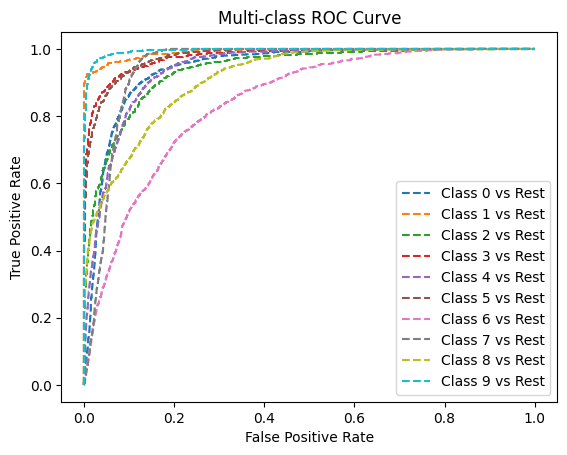

auc_score 0.9463644111111115


In [24]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

# plot.
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle="--", label=f"Class {i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

print("auc_score", roc_auc_score(test_labels_list, test_outputs_list, multi_class="ovo", average="macro"))